# Device failure prediction

##### Device failure prediction is classification issue and this is supervised learning from data resource. I will create Neural Network and Random Forest models by fastai, pytorch and scikit-learn library etc.

##### I would like to mainly use deep learning method to solve the failure detection  problem. because the information(data) is just signal. and Neural network can process the signal very well in high dimension space. i would like to try something.



In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

In [3]:
from fastai.structured import *
from fastai.column_data import *
from IPython.display import HTML
np.set_printoptions(threshold=50, edgeitems=20)

PATH='data/work_sample/'

# Data exploration through summary stats and visualizations

Created device_failure.csv file from following link.

Download link: http://aws-proserve-data-science.s3.amazonaws.com/device_failure.csv

In [4]:
table = pd.read_csv(f'{PATH}device_failure.csv', encoding = "ISO-8859-1",low_memory=False)

#### Dataset check

Feature Space:
* date: date in YYYY-MM-DD
* device: device id
* failure: non-failure is 0, failure is 1
* price: Price when the item is listed
* attribute1 - attribute9: daily aggregated telemetry (unknow the attribute in detail)



In [5]:
display(table.head())

,date,device,failure,attribute1,attribute2,attribute3,attribute4,attribute5,attribute6,attribute7,attribute8,attribute9
0,2015-01-01,S1F01085,0,215630672,56,0,52,6,407438,0,0,7
1,2015-01-01,S1F0166B,0,61370680,0,3,0,6,403174,0,0,0
2,2015-01-01,S1F01E6Y,0,173295968,0,0,0,12,237394,0,0,0
3,2015-01-01,S1F01JE0,0,79694024,0,0,0,6,410186,0,0,0
4,2015-01-01,S1F01R2B,0,135970480,0,0,0,15,313173,0,0,3



###  The dataset hidden the timely information from following information.   (Using the first line device 'S1F01085' etc...)
 

In [6]:
table.sort_values('date',ascending=False)[table['device'] == 'S1F01085']

/home/yanhua/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


,date,device,failure,attribute1,attribute2,attribute3,attribute4,attribute5,attribute6,attribute7,attribute8,attribute9
5812,2015-01-06,S1F01085,0,128832128,56,0,52,6,409404,0,0,7
4651,2015-01-05,S1F01085,0,97393448,56,0,52,6,408114,0,0,7
3489,2015-01-04,S1F01085,0,128073224,56,0,52,6,407439,0,0,7
2326,2015-01-03,S1F01085,0,124017368,56,0,52,6,407438,0,0,7
1163,2015-01-02,S1F01085,0,1650864,56,0,52,6,407438,0,0,7
0,2015-01-01,S1F01085,0,215630672,56,0,52,6,407438,0,0,7


#### Confirmation and analysis on dataset, such as attributes and distribution

In [7]:
display(DataFrameSummary(table).summary())

,date,device,failure,attribute1,attribute2,attribute3,attribute4,attribute5,attribute6,attribute7,attribute8,attribute9
count,NaN,NaN,124494,124494,124494,124494,124494,124494,124494,124494,124494,124494
mean,NaN,NaN,0.000851447,1.22388e+08,159.485,9.94045,1.74112,14.2227,260173,0.292528,0.292528,12.4515
std,NaN,NaN,0.0291673,7.04593e+07,2179.66,185.747,22.9085,15.943,99151.1,7.43692,7.43692,191.426
min,NaN,NaN,0,0,0,0,0,1,8,0,0,0
25%,NaN,NaN,0,6.12848e+07,0,0,0,8,221452,0,0,0
50%,NaN,NaN,0,1.22797e+08,0,0,0,10,249800,0,0,0
75%,NaN,NaN,0,1.8331e+08,0,0,0,12,310266,0,0,0
max,NaN,NaN,1,2.4414e+08,64968,24929,1666,98,689161,832,832,18701
counts,124494,124494,124494,124494,124494,124494,124494,124494,124494,124494,124494,124494
uniques,304,1169,2,123877,558,47,115,60,44838,28,28,65


###  There is a big issue about failure classification. the failure data have less than 0.1% in the dataset.(non-failure is 99.91%, failure is 0.08%) 

###   Imbalanced data problem like fraud detection in banking,real-time bidding in marketing in common. 


In [8]:
len(table),len(table.query('failure > 0')),len(table.query('failure > 0'))/len(table)

(124494, 106, 0.000851446656063746)

# Creation of novel features (Data Preprocessing / Feature Engineering)

#### about solving imbalanced data problem. i would like to use two methods

#### 1 Using markov chain method, Add hadden timely information and create new features for our model (more information for the model)

#### 2 Using the bootstrap method, re-sampled datasets from our original data



In [9]:
table_previous_info = table

### About adding hadden timely information. (more information for the model)

##### Add previous attribute information for the current line group by device.

In [10]:
table_previous_info['previous_attribute1'] = table_previous_info.groupby(['device'])['attribute1'].shift(1)
table_previous_info['previous_attribute2'] = table_previous_info.groupby(['device'])['attribute2'].shift(1)
table_previous_info['previous_attribute3'] = table_previous_info.groupby(['device'])['attribute3'].shift(1)
table_previous_info['previous_attribute4'] = table_previous_info.groupby(['device'])['attribute4'].shift(1)
table_previous_info['previous_attribute5'] = table_previous_info.groupby(['device'])['attribute5'].shift(1)
table_previous_info['previous_attribute6'] = table_previous_info.groupby(['device'])['attribute6'].shift(1)
table_previous_info['previous_attribute7'] = table_previous_info.groupby(['device'])['attribute7'].shift(1)
table_previous_info['previous_attribute8'] = table_previous_info.groupby(['device'])['attribute8'].shift(1)
table_previous_info['previous_attribute9'] = table_previous_info.groupby(['device'])['attribute9'].shift(1)

#### Show the addition result.

In [11]:
table_previous_info.sort_values('date',ascending=False)[table_previous_info['device'] == 'S1F01085']

/home/yanhua/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


,date,device,failure,attribute1,attribute2,attribute3,attribute4,attribute5,attribute6,attribute7,...,attribute9,previous_attribute1,previous_attribute2,previous_attribute3,previous_attribute4,previous_attribute5,previous_attribute6,previous_attribute7,previous_attribute8,previous_attribute9
5812,2015-01-06,S1F01085,0,128832128,56,0,52,6,409404,0,...,7,97393448.0,56.0,0.0,52.0,6.0,408114.0,0.0,0.0,7.0
4651,2015-01-05,S1F01085,0,97393448,56,0,52,6,408114,0,...,7,128073224.0,56.0,0.0,52.0,6.0,407439.0,0.0,0.0,7.0
3489,2015-01-04,S1F01085,0,128073224,56,0,52,6,407439,0,...,7,124017368.0,56.0,0.0,52.0,6.0,407438.0,0.0,0.0,7.0
2326,2015-01-03,S1F01085,0,124017368,56,0,52,6,407438,0,...,7,1650864.0,56.0,0.0,52.0,6.0,407438.0,0.0,0.0,7.0
1163,2015-01-02,S1F01085,0,1650864,56,0,52,6,407438,0,...,7,215630672.0,56.0,0.0,52.0,6.0,407438.0,0.0,0.0,7.0
0,2015-01-01,S1F01085,0,215630672,56,0,52,6,407438,0,...,7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [12]:
len(table_previous_info)

124494

Drop the null value line.

In [13]:
table_previous_info=table_previous_info.dropna()

In [14]:
len(table_previous_info)

123325

Confirm the dataset with null value.

In [15]:
table_previous_info[pd.isnull(table_previous_info).any(axis=1)]

,date,device,failure,attribute1,attribute2,attribute3,attribute4,attribute5,attribute6,attribute7,...,attribute9,previous_attribute1,previous_attribute2,previous_attribute3,previous_attribute4,previous_attribute5,previous_attribute6,previous_attribute7,previous_attribute8,previous_attribute9


In [16]:
len(table.query('failure > 0')),len(table_previous_info.query('failure > 0'))

(106, 106)

# Splitting the data into train and test


### The test dataset must be original data, can't be re-sampled.


In [17]:
train_raw, test = train_test_split(table_previous_info, test_size=0.1)

In [18]:
len(train_raw),len(train_raw.query('failure>0')),len(test),len(test.query('failure>0'))

(110992, 91, 12333, 15)

In [19]:
display(train_raw.head(3))

,date,device,failure,attribute1,attribute2,attribute3,attribute4,attribute5,attribute6,attribute7,...,attribute9,previous_attribute1,previous_attribute2,previous_attribute3,previous_attribute4,previous_attribute5,previous_attribute6,previous_attribute7,previous_attribute8,previous_attribute9
119471,2015-09-17,S1F135GA,0,202904672,0,0,0,8,233944,0,...,0,168497376.0,0.0,0.0,0.0,8.0,232836.0,0.0,0.0,0.0
37100,2015-02-17,Z1F15HYM,0,13940744,0,0,0,8,241267,0,...,0,185524320.0,0.0,0.0,0.0,8.0,241267.0,0.0,0.0,0.0
68860,2015-04-10,Z1F0LH7B,0,231934808,0,0,0,11,464221,0,...,0,225248712.0,0.0,0.0,0.0,11.0,464221.0,0.0,0.0,0.0


In [20]:
display(test.head(3))

,date,device,failure,attribute1,attribute2,attribute3,attribute4,attribute5,attribute6,attribute7,...,attribute9,previous_attribute1,previous_attribute2,previous_attribute3,previous_attribute4,previous_attribute5,previous_attribute6,previous_attribute7,previous_attribute8,previous_attribute9
37611,2015-02-18,W1F1BS9T,0,13012424,0,2,0,12,249714,0,...,5,194302848.0,0.0,2.0,0.0,12.0,249714.0,0.0,0.0,5.0
19214,2015-01-23,Z1F0L3BL,0,16646864,0,0,0,6,305443,0,...,0,59760696.0,0.0,0.0,0.0,6.0,305443.0,0.0,0.0,0.0
17182,2015-01-20,Z1F1A83K,0,117870920,0,0,0,11,27,0,...,0,26285480.0,0.0,0.0,0.0,11.0,27.0,0.0,0.0,0.0


### Bootstrapping, re-sampled training datasets from our original training data


step 1:

Over-sampling

Oversampling is used when the quantity of data is insufficient. It tries to balance dataset by increasing the size of rare samples.


step 2:

Under-sampling

Under-sampling balances the dataset by reducing the size of the abundant class. This method is used when quantity of data is sufficient.




In [21]:
len(train_raw.query('failure > 0')),len(train_raw),(len(train_raw)-len(train_raw.query('failure > 0')))/3,len(train_raw.query('failure > 0'))*300

(91, 110992, 36967.0, 27300)

In [22]:
train_add_tmp = train_raw.query('failure > 0')

In [23]:
train_add = train_add_tmp

In [24]:
len(train_add),len(train_add_tmp)

(91, 91)

In [25]:
for x in range(300):
    frames = [train_add, train_add_tmp]
    train_add = pd.concat(frames)

In [26]:
len(train_add),len(train_add.query('failure > 0')),len(train_add_tmp)*301

(27391, 27391, 27391)

In [27]:
train_t = pd.concat([train_add, train_raw])

In [28]:
train_rest, train_resampling = train_test_split(train_t, test_size=0.333)


##### Bootstrapping, re-sampled training datasets from our original training data

##### Over-sampling 

##### increasing the size from 91 to 9121 for the failure data.

##### Under-sampling

##### reducing the size from 110901 to 36961 for the non-failure data.

Below is the re-sampling result.

In [29]:
len(train_raw),len(train_resampling),len(train_raw.query('failure < 1')),len(train_resampling.query('failure < 1')),len(train_raw.query('failure > 0')),len(train_resampling.query('failure > 0'))

(110992, 46082, 110901, 36961, 91, 9121)

#### Add index key for train dataset and test dataset

In [30]:
train = train_resampling

In [31]:
train['index_col'] = range(1, len(train_resampling) + 1)

/home/yanhua/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [32]:
max(train.index_col),len(train)

(46082, 46082)

In [33]:
test['index_col'] = range(len(train) + 1, len(train) + len(test) + 1)

/home/yanhua/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [34]:
max(test.index_col),max(test.index_col) - len(train),len(test)

(58415, 12333, 12333)

In [35]:
train.head().T.head(40)

,100457,105487,35868,14883,117456
date,2015-07-07,2015-07-22,2015-02-16,2015-01-17,2015-09-03
device,W1F0Z3FW,S1F12XGM,S1F0S6GZ,W1F1CLED,W1F17D9Z
failure,0,0,0,0,0
attribute1,54137544,106519592,54466288,97607768,148862160
attribute2,0,0,0,0,0
attribute3,0,0,0,0,0
attribute4,0,0,0,0,0
attribute5,8,8,12,9,11
attribute6,235228,287236,271941,424306,227245
attribute7,0,0,0,0,0


In [36]:
len(train),len(test)

(46082, 12333)


#### Because neural network can use the embedding method transform the category variable to the high dimension vector value. we should make decision about category variable or continue variable. but unfortunately i have not more attribute information in detail. so I have confirmed the data and set all to continue variable. 




In [37]:
cat_vars = []
drop_vars = ['date','device']
contin_vars = ['attribute1', 'attribute2', 'attribute3', 'attribute4', 'attribute5', 'attribute6', 'attribute7', 'attribute8', 'attribute9','previous_attribute1','previous_attribute2','previous_attribute3','previous_attribute4','previous_attribute5','previous_attribute6','previous_attribute7','previous_attribute8','previous_attribute9']
index = 'index_col'
n = len(train); n
for df in (test,train):
    df.set_index(index)


In [38]:
dep = 'failure'

train = train[cat_vars+contin_vars+[dep, 'index_col']].copy()

In [39]:
test = test[cat_vars+contin_vars+[dep, 'index_col']].copy()

In [40]:
train.shape

(46082, 20)

In [41]:
for v in cat_vars: train[v] = train[v].astype('category').cat.as_ordered()

In [42]:
apply_cats(test, train)

In [43]:
for v in contin_vars:
    train[v] = train[v].astype('float32')
    test[v] = test[v].astype('float32')

#### Normalization data values and setting the x_lable_data ,y_lable_data for training the neural network.

In [44]:
df, y, nas, mapper = proc_df(train, dep, do_scale=True)

In [45]:
y

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, ..., 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1,
       1, 0, 0, 0, 1, 1, 0, 0])

In [46]:
df.head(3)

,attribute1,attribute2,attribute3,attribute4,attribute5,attribute6,attribute7,attribute8,attribute9,previous_attribute1,previous_attribute2,previous_attribute3,previous_attribute4,previous_attribute5,previous_attribute6,previous_attribute7,previous_attribute8,previous_attribute9,index_col
100457,-0.976615,-0.142938,-0.056502,-0.12293,-0.414239,-0.272033,-0.099116,-0.099116,-0.084927,-0.017039,-0.133083,-0.056461,-0.115218,-0.412451,-0.268538,-0.106954,-0.106954,-0.084915,-1.732013
105487,-0.227493,-0.142938,-0.056502,-0.12293,-0.414239,0.253266,-0.099116,-0.099116,-0.079281,-0.559850,-0.133083,-0.056461,-0.115218,-0.412451,0.243192,-0.106954,-0.106954,-0.079269,-1.731938
35868,-0.971913,-0.142938,-0.056502,-0.12293,-0.164104,0.098781,-0.099116,-0.099116,-0.084927,-1.665794,-0.133083,-0.056461,-0.115218,-0.162450,0.102397,-0.106954,-0.106954,-0.084915,-1.731863


In [47]:
df_test, _, nas, mapper = proc_df(test, dep, do_scale=True, mapper=mapper, na_dict=nas)

In [48]:
df_test.head(3)

,attribute1,attribute2,attribute3,attribute4,attribute5,attribute6,attribute7,attribute8,attribute9,previous_attribute1,previous_attribute2,previous_attribute3,previous_attribute4,previous_attribute5,previous_attribute6,previous_attribute7,previous_attribute8,previous_attribute9,index_col
37611,-1.564750,-0.142938,-0.043900,-0.12293,-0.164104,-0.125719,-0.099116,-0.099116,-0.056698,1.010712,-0.133083,-0.043858,-0.115218,-0.162450,-0.122177,-0.106954,-0.106954,-0.056687,1.732088
19214,-1.512773,-0.142938,-0.056502,-0.12293,-0.539307,0.437162,-0.099116,-0.099116,-0.084927,-0.895103,-0.133083,-0.056461,-0.115218,-0.537452,0.440890,-0.106954,-0.106954,-0.084915,1.732164
17182,-0.065156,-0.142938,-0.056502,-0.12293,-0.226638,-2.647641,-0.099116,-0.099116,-0.084927,-1.369286,-0.133083,-0.056461,-0.115218,-0.224951,-2.644929,-0.106954,-0.106954,-0.084915,1.732239


In [49]:
mapper

DataFrameMapper(default=False, df_out=False,
        features=[(['attribute1'], StandardScaler(copy=True, with_mean=True, with_std=True)), (['attribute2'], StandardScaler(copy=True, with_mean=True, with_std=True)), (['attribute3'], StandardScaler(copy=True, with_mean=True, with_std=True)), (['attribute4'], StandardScaler(copy=True, with_mean=True, wit...an=True, with_std=True)), (['index_col'], StandardScaler(copy=True, with_mean=True, with_std=True))],
        input_df=False, sparse=False)

In [50]:
display(DataFrameSummary(df).summary())

,attribute1,attribute2,attribute3,attribute4,attribute5,attribute6,attribute7,attribute8,attribute9,previous_attribute1,previous_attribute2,previous_attribute3,previous_attribute4,previous_attribute5,previous_attribute6,previous_attribute7,previous_attribute8,previous_attribute9,index_col
count,46082,46082,46082,46082,46082,46082,46082,46082,46082,46082,46082,46082,46082,46082,46082,46082,46082,46082,46082
mean,-4.91593e-08,-7.24573e-09,1.29821e-09,1.65371e-09,-1.26155e-08,6.38225e-08,-2.1717e-09,-2.1717e-09,3.64637e-09,1.09638e-07,1.2106e-08,-1.40392e-09,-3.42541e-09,5.82456e-09,1.92238e-07,-5.43668e-09,-5.43668e-09,8.14227e-10,4.77028e-19
std,1.00001,1.00001,1.00001,1.00001,1.00001,1.00001,1.00001,1.00001,1.00001,1.00001,1.00001,1.00001,1.00001,1.00001,1.00001,1.00001,1.00001,1.00001,1.00001
min,-1.75084,-0.142938,-0.0565021,-0.12293,-0.851977,-2.64783,-0.099116,-0.099116,-0.0849269,-1.74162,-0.133083,-0.0564613,-0.115218,-0.849953,-2.64512,-0.106954,-0.106954,-0.0849152,-1.73201
25%,-0.857709,-0.142938,-0.0565021,-0.12293,-0.414239,-0.396254,-0.099116,-0.099116,-0.0849269,-0.844042,-0.133083,-0.0564613,-0.115218,-0.412451,-0.394864,-0.106954,-0.106954,-0.0849152,-0.866007
50%,0.0195122,-0.142938,-0.0565021,-0.12293,-0.289172,-0.0727631,-0.099116,-0.099116,-0.0849269,-0.00104267,-0.133083,-0.0564613,-0.115218,-0.287451,-0.0737297,-0.106954,-0.106954,-0.0849152,0
75%,0.860788,-0.142938,-0.0565021,-0.12293,-0.10157,0.48925,-0.099116,-0.099116,-0.0849269,0.844954,-0.133083,-0.0564613,-0.115218,-0.09995,0.491277,-0.106954,-0.106954,-0.0849152,0.866007
max,1.74058,10.7909,157.029,18.6073,5.21381,4.31284,20.1601,20.1601,105.495,1.7166,12.756,157.034,18.7767,5.21257,4.31685,30.1745,30.1745,105.495,1.73201
counts,46082,46082,46082,46082,46082,46082,46082,46082,46082,46082,46082,46082,46082,46082,46082,46082,46082,46082,46082
uniques,36932,359,44,82,60,20286,22,22,61,36947,348,43,80,60,20203,21,21,61,46082


In [51]:
display(DataFrameSummary(df_test).summary())

,attribute1,attribute2,attribute3,attribute4,attribute5,attribute6,attribute7,attribute8,attribute9,previous_attribute1,previous_attribute2,previous_attribute3,previous_attribute4,previous_attribute5,previous_attribute6,previous_attribute7,previous_attribute8,previous_attribute9,index_col
count,12333,12333,12333,12333,12333,12333,12333,12333,12333,12333,12333,12333,12333,12333,12333,12333,12333,12333,12333
mean,-0.00601324,-0.115895,0.0109162,-0.104535,-0.024793,-0.0210266,-0.0889597,-0.0889597,-0.0175553,-0.0130367,-0.10286,0.0109592,-0.0972322,-0.0234628,-0.0204166,-0.093129,-0.093129,-0.0175489,2.1956
std,1.00622,0.368478,1.59228,0.206075,0.999556,0.982899,0.268182,0.268182,0.914389,0.996153,0.415919,1.59233,0.198496,0.998953,0.982492,0.374495,0.374495,0.914391,0.267642
min,-1.75081,-0.142938,-0.0565021,-0.12293,-0.851977,-2.64783,-0.099116,-0.099116,-0.0849269,-1.74162,-0.133083,-0.0564613,-0.115218,-0.849953,-2.64512,-0.106954,-0.106954,-0.0849152,1.73209
25%,-0.878889,-0.142938,-0.0565021,-0.12293,-0.414239,-0.4077,-0.099116,-0.099116,-0.0849269,-0.873143,-0.133083,-0.0564613,-0.115218,-0.412451,-0.406787,-0.106954,-0.106954,-0.0849152,1.96385
50%,-0.00241941,-0.142938,-0.0565021,-0.12293,-0.289172,-0.128446,-0.099116,-0.099116,-0.0849269,-0.0112476,-0.133083,-0.0564613,-0.115218,-0.287451,-0.126592,-0.106954,-0.106954,-0.0849152,2.1956
75%,0.866754,-0.142938,-0.0565021,-0.12293,-0.164104,0.486593,-0.099116,-0.099116,-0.0849269,0.845378,-0.133083,-0.0564613,-0.115218,-0.16245,0.488155,-0.106954,-0.106954,-0.0849152,2.42736
max,1.74053,10.7895,157.029,9.33212,5.21381,4.29912,22.5563,22.5563,57.1455,1.7162,12.7544,157.034,8.53695,5.21257,4.30384,34.1242,34.1242,57.1456,2.65912
counts,12333,12333,12333,12333,12333,12333,12333,12333,12333,12333,12333,12333,12333,12333,12333,12333,12333,12333,12333
uniques,12317,192,37,51,59,8994,15,15,52,12309,195,37,51,59,8982,14,14,52,12333


# Hyperparameter tuning  (Training model)

#### Generate a classification neural network model 

In [52]:
n = len(train); n

46082

In [53]:
cat_sz = [(c, len(train[c].cat.categories)+1) for c in cat_vars]
emb_szs = [(c, min(50, (c+1)//2)) for _,c in cat_sz]
torch.cuda.is_available()

True

In [54]:
val_idx = get_cv_idxs(n, val_pct=0.2)

In [55]:
md = ColumnarModelData.from_data_frame(PATH, val_idx, df, y.astype('int'), cat_flds=cat_vars, bs=15,
                                      is_reg=False,is_multi=False,test_df=df_test)

In [56]:
m = md.get_learner(emb_szs, len(df.columns)-len(cat_vars),0.06, 2, [100,50], [0.03,0.06],None,True)

#### Information of the neural network model

In [57]:
m

MixedInputModel(
  (embs): ModuleList(
  )
  (lins): ModuleList(
    (0): Linear(in_features=19, out_features=100, bias=True)
    (1): Linear(in_features=100, out_features=50, bias=True)
  )
  (bns): ModuleList(
    (0): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True)
    (1): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True)
  )
  (outp): Linear(in_features=50, out_features=2, bias=True)
  (emb_drop): Dropout(p=0.06)
  (drops): ModuleList(
    (0): Dropout(p=0.03)
    (1): Dropout(p=0.06)
  )
  (bn): BatchNorm1d(19, eps=1e-05, momentum=0.1, affine=True)
)

#### Finding the learning rate.

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 66%|██████▌   | 1621/2458 [00:04<00:02, 349.74it/s, loss=1.28] 


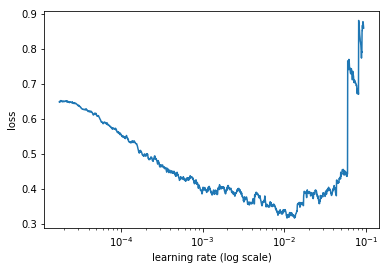

In [58]:
m.lr_find()
m.sched.plot(100)

In [59]:
lr = .001

In [60]:
m.fit(lr, 15, cycle_len=3)

HBox(children=(IntProgress(value=0, description='Epoch', max=45), HTML(value='')))

epoch      trn_loss   val_loss                                  
    0      0.257501   0.270341  
    1      0.22074    0.221069                                  
    2      0.217918   0.213712                                  
    3      0.206231   0.176881                                  
    4      0.162647   0.148789                                  
    5      0.146029   0.14167                                   
    6      0.150536   0.122065                                  
    7      0.119409   0.106896                                  
    8      0.109403   0.098717                                   
    9      0.12503    0.09441                                   
    10     0.082819   0.07814                                    
    11     0.115148   0.074257                                   
    12     0.09648    0.074623                                   
    13     0.07679    0.064511                                   
    14     0.089004   0.060577                      

[array([0.02251])]

# Performance on test dataset

In [61]:
pred_test=m.predict(is_test=True)
np.argmax(m.predict(True), axis =1)
suba = pd.DataFrame({'index_col':test.index_col, 'failure':test.failure, 'failure_pred':np.argmax(m.predict(True), axis =1)})[['index_col', 'failure','failure_pred']]
suba.head(1)

,index_col,failure,failure_pred
37611,46083,0,0



### Accuracy (正解率)

##### Accuracy = (TP + TN) / (TP + TN + FP + FN)

### the accuracy rate is 99.1%

In [62]:
accuracy_score(suba.failure,suba.failure_pred)

0.9912430065677451


### Confusion matrix (多クラスの混同行列)

### About business goal for the device failure prediction, must be focus the recall rate and precision rate.

##### for the model 60% (9/15) failure be detected 


精度 (Precision)

Precision = TP / (TP + FP)

#### For the failure detection, The Precision is 8.1%  9/(9+102)

検出率 (Recall)

Recall = TPR = Sensitivity = TP / (TP + FN)

### For the failure detection, The Recall rate is 60%   9/(9+6)

In [63]:
confusion_matrix(suba.failure,suba.failure_pred)

array([[12216,   102],
       [    6,     9]])

##### save the neural network model.

In [64]:
m.save('device_failure_model_v2')

# Cross validation

In [65]:
def chunkit(seq, num):
    avg = len(seq) / float(num)
    out = []
    last = 0.0

    while last < len(seq):
        out.append(seq[int(last):int(last + avg)])
        last += avg

    return out

In [66]:
cross_val_range=chunkit(range(len(train)),5)

### cross_validation training for the neural network model

In [67]:
lr = .001

In [68]:
for x in cross_val_range:
    print('Cross Validation:')
    print(x)
    val_idx=list(x)
    md = ColumnarModelData.from_data_frame(PATH, val_idx, df, y.astype('int'), cat_flds=cat_vars, bs=4,
                                      is_reg=False,is_multi=False,test_df=df_test)
    m = md.get_learner(emb_szs, len(df.columns)-len(cat_vars),0.06, 2, [100,50], [0.03,0.06],None,True)
    if val_idx[0] > 10:
        m.load('device_failure_model')
        print('loading the model')
    lr = .001
#    m.fit(lr, 4, cycle_len=2, cycle_mult=2)
    m.fit(lr, 4)
    m.save('device_failure_model')
    (x,y1)=m.predict_with_targs()
    aa = accuracy_score(y1,np.argmax(x,axis=1))
    bb = confusion_matrix(y1,np.argmax(x,axis=1))
    print ('Accuracy:',aa)
    print ('Confusion matrix:')
    print (bb)
    print ('-----------------------------------------')

Cross Validation:
range(0, 9216)


HBox(children=(IntProgress(value=0, description='Epoch', max=4), HTML(value='')))

epoch      trn_loss   val_loss                                  
    0      0.250345   0.221908  
    1      0.208306   0.166886                                  
    2      0.104596   0.110049                                   
    3      0.10163    0.091357                                   

Accuracy: 0.9601779513888888
Confusion matrix:
[[7279  133]
 [ 234 1570]]
-----------------------------------------
Cross Validation:
range(9216, 18432)
loading the model


HBox(children=(IntProgress(value=0, description='Epoch', max=4), HTML(value='')))

epoch      trn_loss   val_loss                                   
    0      0.072888   0.088123  
    1      0.093796   0.076099                                   
    2      0.103427   0.081603                                   
    3      0.087711   0.070119                                   

Accuracy: 0.9684244791666666
Confusion matrix:
[[7237  133]
 [ 158 1688]]
-----------------------------------------
Cross Validation:
range(18432, 27649)
loading the model


HBox(children=(IntProgress(value=0, description='Epoch', max=4), HTML(value='')))

epoch      trn_loss   val_loss                                   
    0      0.075496   0.062129  
    1      0.056037   0.054145                                   
    2      0.08881    0.048717                                   
    3      0.057163   0.052145                                   

Accuracy: 0.9803623738743625
Confusion matrix:
[[7268  113]
 [  68 1768]]
-----------------------------------------
Cross Validation:
range(27649, 36865)
loading the model


HBox(children=(IntProgress(value=0, description='Epoch', max=4), HTML(value='')))

epoch      trn_loss   val_loss                                   
    0      0.044592   0.040268  
    1      0.080642   0.055523                                   
    2      0.073758   0.056853                                   
    3      0.062028   0.055598                                   

Accuracy: 0.9853515625
Confusion matrix:
[[7300   72]
 [  63 1781]]
-----------------------------------------
Cross Validation:
range(36865, 46082)
loading the model


HBox(children=(IntProgress(value=0, description='Epoch', max=4), HTML(value='')))

epoch      trn_loss   val_loss                                   
    0      0.042792   0.029432  
    1      0.05307    0.037692                                   
    2      0.042632   0.026256                                   
    3      0.068418   0.06754                                    

Accuracy: 0.980796354562222
Confusion matrix:
[[7281  145]
 [  32 1759]]
-----------------------------------------


# Cross validation Performance on test dataset

In [69]:
pred_test=m.predict(is_test=True)
np.argmax(m.predict(True), axis =1)
suba = pd.DataFrame({'index_col':test.index_col, 'failure':test.failure, 'failure_pred':np.argmax(m.predict(True), axis =1)})[['index_col', 'failure','failure_pred']]
suba.head(1)

,index_col,failure,failure_pred
37611,46083,0,0



### Accuracy (正解率)

##### Accuracy = (TP + TN) / (TP + TN + FP + FN)

### the accuracy rate is 97.9%

In [70]:
accuracy_score(suba.failure,suba.failure_pred)

0.9793237655071759

### Confusion matrix (多クラスの混同行列)

### About business goal for the device failure prediction, must be focus the recall rate and precision rate.

##### for the model 60% (9/15) failure be detected 


精度 (Precision)

Precision = TP / (TP + FP)

#### For the failure detection, The Precision is 3.4% 9/(9+249)

検出率 (Recall)

Recall = TPR = Sensitivity = TP / (TP + FN)

### For the failure detection, The Recall rate is 60% 9/(9+6)

In [71]:
confusion_matrix(suba.failure,suba.failure_pred)

array([[12069,   249],
       [    6,     9]])

##### save the neural network model.

In [72]:
m.save('device_failure_model_cv_v2')

# Minimize false positives instead of accuracy or misclassification error
    I have tried a lot of thing about the false positives result. 
    For example:
        Using markov chain method, Add hadden timely information and create new features for our model. (more information for the model)
        Using the bootstrap method, re-sampled datasets from our original data.
        etc...


# Comparing performace of multiple machine learning algorithms
    
    using random forest algorithms to create prediction model

    About the recall rate , neural network is higher than the random forest.

# Random Forest

In [73]:
from sklearn.ensemble import RandomForestRegressor

In [74]:
((val,trn), (y_val,y_trn)) = split_by_idx(val_idx, df.values, y)

In [75]:
m = RandomForestRegressor(n_estimators=40, max_features=0.99, min_samples_leaf=2,
                          n_jobs=-1, oob_score=True)
m.fit(trn, y_trn);

In [76]:
def PredtoClass(a):
    pred_class = []
    for i in range(len(a)):
        if a[i]<.5:
            pred_class.append(0)
        else:
            pred_class.append(1)
    return pred_class
def accuracy(preds, y_val):
    return  sum(1- abs(PredtoClass(preds) - y_val))/len(y_val)

In [77]:
preds = m.predict(val)
m.score(trn, y_trn), m

(0.9978011294702782,
 RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
            max_features=0.99, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=2, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=40, n_jobs=-1,
            oob_score=True, random_state=None, verbose=0, warm_start=False))

In [78]:
preds_test = m.predict(df_test.values)

In [79]:
sub = pd.DataFrame({'index_col':test.index_col, 'failure':test.failure, 'failure_pred':PredtoClass(preds_test)})[['index_col', 'failure', 'failure_pred']]
sub.head(10)

,index_col,failure,failure_pred
37611,46083,0,0
19214,46084,0,0
17182,46085,0,0
79647,46086,0,0
58407,46087,0,0
67250,46088,0,0
18770,46089,0,0
28491,46090,0,0
60058,46091,0,0
41815,46092,0,0


In [80]:
accuracy_score(sub.failure,sub.failure_pred)

0.9977296683694153

In [81]:
confusion_matrix(sub.failure,sub.failure_pred)

array([[12302,    16],
       [   12,     3]])


### Confusion matrix (多クラスの混同行列)

### About business goal for the device failure prediction, must be focus the recall rate and precision rate.

##### for the model 60% (9/15) failure be detected 


精度 (Precision)

Precision = TP / (TP + FP)

#### For the failure detection, The Precision is 15% 3/(3+16)

検出率 (Recall)

Recall = TPR = Sensitivity = TP / (TP + FN)

### For the failure detection, The Recall rate is 20% 3/(12+3)

# Conclusion
    I have tried three methods for solving the devices failure problem.
    1 add timely information 
    2 bootstrapping dataset
    3 cross viludation
    
    Using neural network to solve the unbalanced dataset is big business chance and big challenge. maybe there are some new idea like human or biology for detecting the failure. we need deeply thinking and finding the new neural network architecture or new method for solving real world problem.
    